# CS-5824 / Advanced Machine Learning
# Assignment 2 Section B [ 40 Points ]

In this assignment, **you need to complete two sections** which are based on:

1. Decision Trees (20 points)
2. Support Vector Machines (20 points)

## Submission guidelines

1. Click the Save button at the top of the notebook.
2. Please make sure to enter your Virginia Tech PID below.
3. Select Edit -> Clear All Output. This will clear all the outputs from all cells (but will keep the content of all cells).
4. Select Runtime -> Restart and Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Print -> Save as PDF.
6. Look at the PDF file and make sure all your solutions are there and correctly displayed. 
7. Upload **both** the PDF file (saved in step 5) and this notebook.
8. Please **DO NOT** upload any data.

### Your VT PID: amartya

# Section 0. Environment Set Up

Mount your Google Drive in Google Colab:

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


Upload all files in the zip to a directory in your Google Drive, then append it to your Python path using sys (please modify `customized_path_to_your_homework` to be the path to your directory):

In [ ]:
import sys
from pathlib import Path

prefix = "/content/gdrive/My Drive/"
customized_path_to_your_homework = "CS 5824 ML/HW2/"
sys_path = prefix + customized_path_to_your_homework
sys.path.append(sys_path)
data_path = Path(sys_path) / "Data"

Run some setup code for this notebook. For all randomization done in this assignment, please use the `seed` below as the random state.

In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.exceptions import ConvergenceWarning
import warnings

# We ignore the convergence warnings in this homework, as some of the exercise will
# always trigger this warning.
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Seed for all randomization
seed = 5824

# Section 1. Decision Trees [ 15 points ]

For this problem, we will use a decision tree classifier on a toy dataset provided by SciKit-Learn. We will experiment with the [Wine dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data). The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine. The features include:

<ol>
  <li>Alcohol</li>
  <li>Malic acid</li>
  <li>Ash</li>
  <li>Alcalinity of ash</li>
  <li>Magnesium</li>
  <li>Total phenols</li>
  <li>Flavanoids</li>
  <li>Nonflavanoid phenols</li>
  <li>Proanthocyanins</li>
  <li>Color intensity</li>
  <li>Hue</li>
  <li>OD280/OD315 of diluted wines</li>
  <li>Proline</li>
</ol>

The 3 classes are `class_0`, `class_1`, and `class_2`.

## 1.1. Data Preparation

First, we need to load the dataset from SciKit-Learn. The `load_wine()` function returns a `sklearn.utils.Bunch` object containing all information about the dataset, such as feature and target names, as well as the full description of the data in its `DESCR` property.

In [ ]:
# Load dataset
from sklearn.datasets import load_wine

wine_dataset = load_wine()
feature_names = wine_dataset.feature_names
target_names = wine_dataset.target_names
wine_X, wine_y = wine_dataset.data, wine_dataset.target
print(wine_dataset.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

Normalize the data, then split it into train (80%) and test (20%) sets using the provided `seed` and with stratification:

In [ ]:
from pandas.core import window
#Normalizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(wine_X)
wine_X_normalised = scaler.transform(wine_X)
wine_X_normalised

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

In [ ]:
# TODO: Preprocess data
from sklearn.model_selection import train_test_split
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split( wine_X_normalised, wine_y, test_size=0.2, random_state=seed)

In [ ]:
wine_X_train.shape, wine_X_test.shape

((142, 13), (36, 13))

For ease of visualization, we will be using only the first 2 features ("Alcohol" and "Malic acid"). Visualize the train set below:

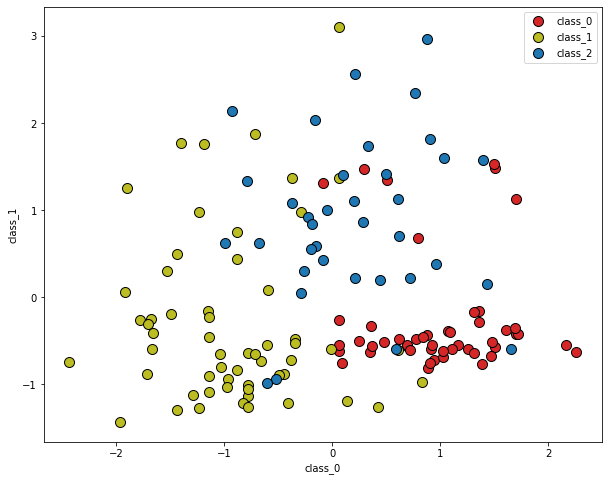

In [ ]:
colors = ["tab:red", "tab:olive", "tab:blue"]
feature1, feature2 = 0, 1 # Chosen features
for label, color in zip(range(len(target_names)), colors):
    idx = np.where(wine_y_train == label)
    plt.scatter(
        wine_X_train[idx, feature1],
        wine_X_train[idx, feature2],
        s=100,
        color=color,
        edgecolor="black",
        label=target_names[label]
    )
plt.xlabel(target_names[0])
plt.ylabel(target_names[1])
plt.legend()
plt.show()

## 1.2. Training a Decision Tree (5 points)

Using [`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), train a decision tree classifier with entropy as the purity criterion, the provided `seed` as the random state, and a maximum depth of 3.

In [ ]:
# TODO: Train your decision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = 'entropy',random_state=seed, max_depth=3)

Plot your decision tree as a graph:

In [ ]:
clf.fit(wine_X_train[:,:2],wine_y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=5824)

[Text(0.4230769230769231, 0.875, 'X[0] <= -0.273\nentropy = 1.56\nsamples = 142\nvalue = [49, 57, 36]'),
 Text(0.15384615384615385, 0.625, 'X[0] <= -1.008\nentropy = 0.579\nsamples = 58\nvalue = [0, 50, 8]'),
 Text(0.07692307692307693, 0.375, 'entropy = 0.0\nsamples = 26\nvalue = [0, 26, 0]'),
 Text(0.23076923076923078, 0.375, 'X[1] <= -0.212\nentropy = 0.811\nsamples = 32\nvalue = [0, 24, 8]'),
 Text(0.15384615384615385, 0.125, 'entropy = 0.469\nsamples = 20\nvalue = [0, 18, 2]'),
 Text(0.3076923076923077, 0.125, 'entropy = 1.0\nsamples = 12\nvalue = [0, 6, 6]'),
 Text(0.6923076923076923, 0.625, 'X[1] <= -0.001\nentropy = 1.281\nsamples = 84\nvalue = [49, 7, 28]'),
 Text(0.5384615384615384, 0.375, 'X[1] <= -0.894\nentropy = 0.715\nsamples = 49\nvalue = [42, 5, 2]'),
 Text(0.46153846153846156, 0.125, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3, 0]'),
 Text(0.6153846153846154, 0.125, 'entropy = 0.513\nsamples = 46\nvalue = [42, 2, 2]'),
 Text(0.8461538461538461, 0.375, 'X[0] <= 1.463\nen

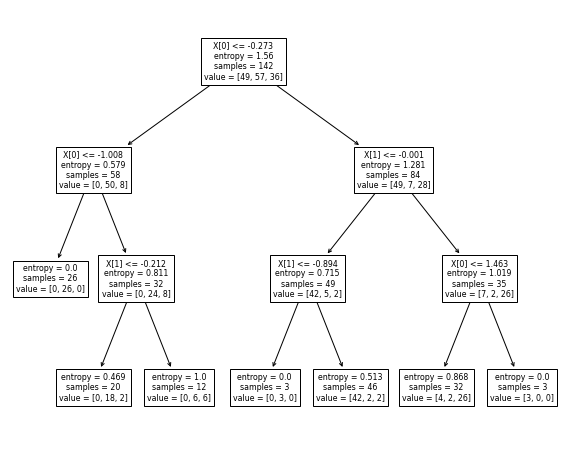

In [ ]:
from sklearn.tree import plot_tree

plot_tree(clf)

We can also plot the decision boundaries using the `sklearn.inspection.DecisionBoundaryDisplay` class—in particular, its `from_estimator()` method—which is [new in SciKit-Learn 1.1.2](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#sklearn.inspection.DecisionBoundaryDisplay). Due to package availability reasons, we include it in the attached `utils.py` file.

In [ ]:
from utils import DecisionBoundaryDisplay

def plot_decision_boundary(clf, X, y, chosen_features, feature_names, target_names):
    feature1, feature2 = chosen_features
    fig, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        np.column_stack((X[:, feature1], X[:, feature2])),
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
    )

    for label, color in zip(range(len(target_names)), colors):
        idx = np.where(y == label)
        plt.scatter(
            X[idx, feature1],
            X[idx, feature2],
            s=100,
            color=color,
            edgecolor="black",
            label=target_names[label]
        )

    plt.xlabel(feature_names[feature1])
    plt.ylabel(feature_names[feature2])
    plt.legend()
    plt.tight_layout()

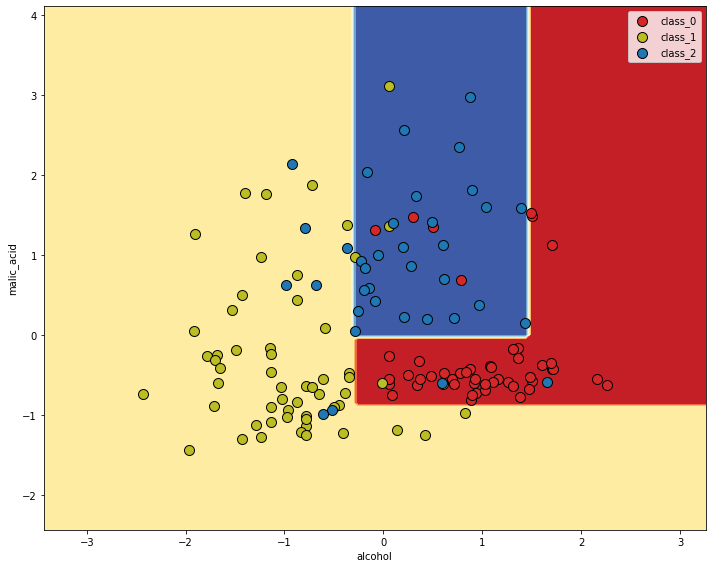

In [ ]:
plot_decision_boundary(
    clf,
    wine_X_train,
    wine_y_train,
    (feature1, feature2),
    feature_names,
    target_names
)

## 1.3. Predicting (10 points)

There are two different functions for prediction within `DecisionTreeClassifier`. 

(1) What are they? Invoke them on the test set in the cells below and look at the outputs. How are they different? How are they related? (2 points)

**_Your answer:_** 
The two different functions to predict using DecisionTreeClassifier are predict() and predict_proba(). The first one predicts the class for each sample while the second one predicts the class probabilities for each input. For each sample, the class with the highest probability as predicted by predict_proba() is the one predicted by predict() method.

In [ ]:
# TODO: Predict function 1
clf.predict(wine_X_test[:,:2])

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 2, 0, 1, 0, 1, 2,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 0, 1, 2, 1])

In [ ]:
# TODO: Predict function 2
clf.predict_proba(wine_X_test[:,:2])

array([[0.        , 1.        , 0.        ],
       [0.        , 0.9       , 0.1       ],
       [0.91304348, 0.04347826, 0.04347826],
       [0.91304348, 0.04347826, 0.04347826],
       [0.91304348, 0.04347826, 0.04347826],
       [0.91304348, 0.04347826, 0.04347826],
       [0.91304348, 0.04347826, 0.04347826],
       [0.91304348, 0.04347826, 0.04347826],
       [0.        , 0.5       , 0.5       ],
       [0.125     , 0.0625    , 0.8125    ],
       [0.        , 1.        , 0.        ],
       [0.91304348, 0.04347826, 0.04347826],
       [0.125     , 0.0625    , 0.8125    ],
       [0.125     , 0.0625    , 0.8125    ],
       [0.        , 0.9       , 0.1       ],
       [0.91304348, 0.04347826, 0.04347826],
       [0.125     , 0.0625    , 0.8125    ],
       [0.91304348, 0.04347826, 0.04347826],
       [0.        , 0.5       , 0.5       ],
       [0.91304348, 0.04347826, 0.04347826],
       [0.        , 1.        , 0.        ],
       [0.125     , 0.0625    , 0.8125    ],
       [0.

(2) Compute the accuracy, precision, and F1-score to assess your decision tree's performance below. How is the performance? (3 points)

**_Your answer:_**

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [ ]:
from os import access
# TODO: Evaluate decision tree's performance
accuracy = clf.score(wine_X_test[:,:2],wine_y_test)
precision = precision_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')
f1 = f1_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("F1 score: ",f1)

Accuracy:  0.75
Precision:  0.7430555555555555
F1 score:  0.7313131313131312


(3) Experiment with different parameters (*e.g.*, depth, selection criterion) and observe the change in decision boundaries as well as the evaluation scores. Report the optimal configuration and its corresponding scores. How does changing the depth improve or worsen the performance of the decision tree, specifically in the context of this dataset? (5 points)

**_Your answer:_**

Accuracy:  0.75
Precision:  0.7430555555555555
F1 score:  0.7313131313131312


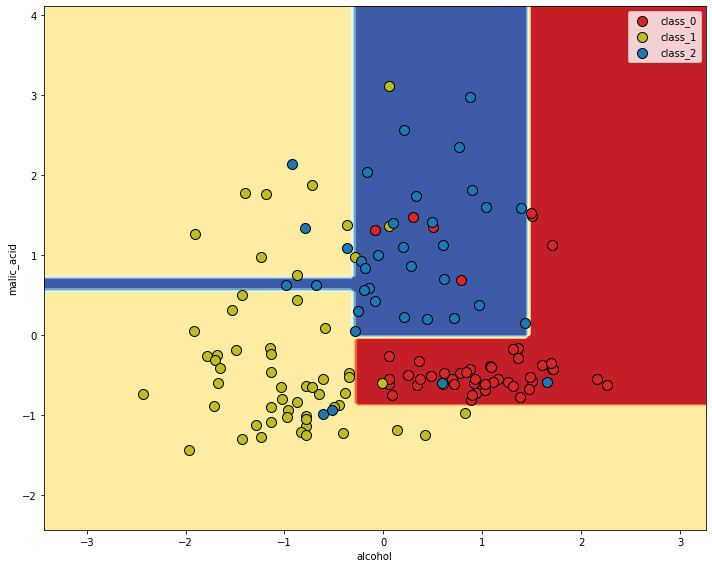

In [ ]:
#Setup0
clf = DecisionTreeClassifier(criterion = 'gini',random_state=seed, max_depth=3)
clf.fit(wine_X_train[:,:2],wine_y_train)
plot_decision_boundary(
    clf,
    wine_X_train,
    wine_y_train,
    (feature1, feature2),
    feature_names,
    target_names
)
accuracy = clf.score(wine_X_test[:,:2],wine_y_test)
precision = precision_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')
f1 = f1_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("F1 score: ",f1)

Accuracy:  0.7777777777777778
Precision:  0.7703703703703703
F1 score:  0.7634970393591082


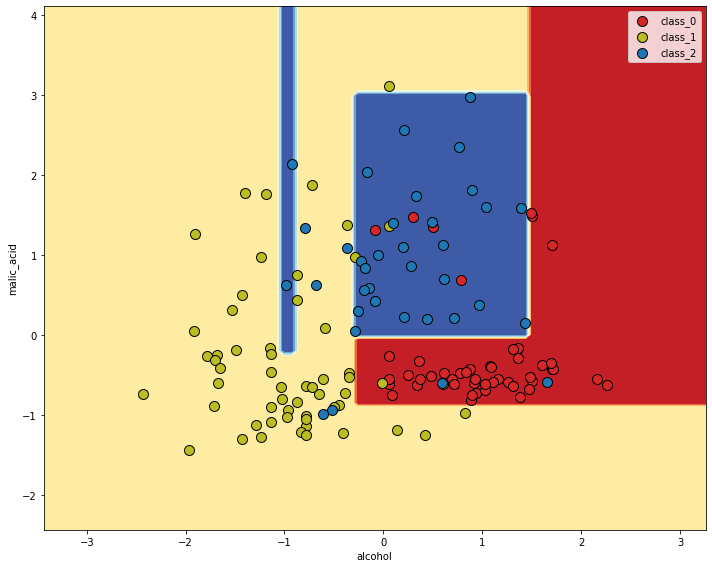

In [ ]:
#Setup1
clf = DecisionTreeClassifier(criterion = 'entropy',random_state=seed, max_depth=4)
clf.fit(wine_X_train[:,:2],wine_y_train)
plot_decision_boundary(
    clf,
    wine_X_train,
    wine_y_train,
    (feature1, feature2),
    feature_names,
    target_names
)
accuracy = clf.score(wine_X_test[:,:2],wine_y_test)
precision = precision_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')
f1 = f1_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("F1 score: ",f1)

Accuracy:  0.75
Precision:  0.7592592592592592
F1 score:  0.7386695906432749


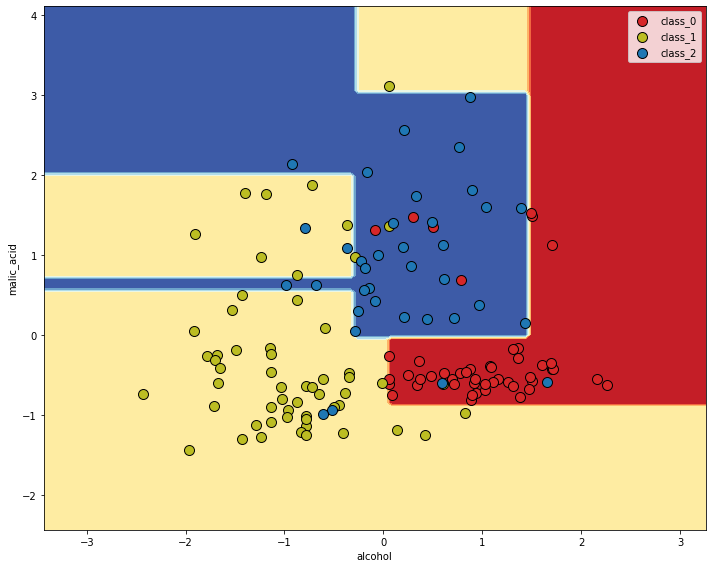

In [ ]:
#Setup2
clf = DecisionTreeClassifier(criterion = 'gini',random_state=seed, max_depth=4)
clf.fit(wine_X_train[:,:2],wine_y_train)
plot_decision_boundary(
    clf,
    wine_X_train,
    wine_y_train,
    (feature1, feature2),
    feature_names,
    target_names
)
accuracy = clf.score(wine_X_test[:,:2],wine_y_test)
precision = precision_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')
f1 = f1_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("F1 score: ",f1)

Accuracy:  0.7777777777777778
Precision:  0.7703703703703703
F1 score:  0.7634970393591082


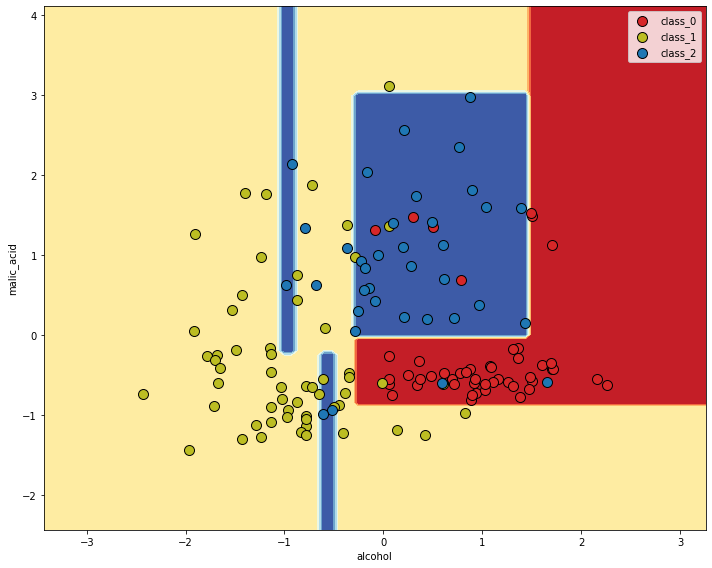

In [ ]:
#Setup3
clf = DecisionTreeClassifier(criterion = 'entropy',random_state=seed, max_depth=5)
clf.fit(wine_X_train[:,:2],wine_y_train)
plot_decision_boundary(
    clf,
    wine_X_train,
    wine_y_train,
    (feature1, feature2),
    feature_names,
    target_names
)
accuracy = clf.score(wine_X_test[:,:2],wine_y_test)
precision = precision_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')
f1 = f1_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("F1 score: ",f1)

Accuracy:  0.75
Precision:  0.75
F1 score:  0.7466977466977466


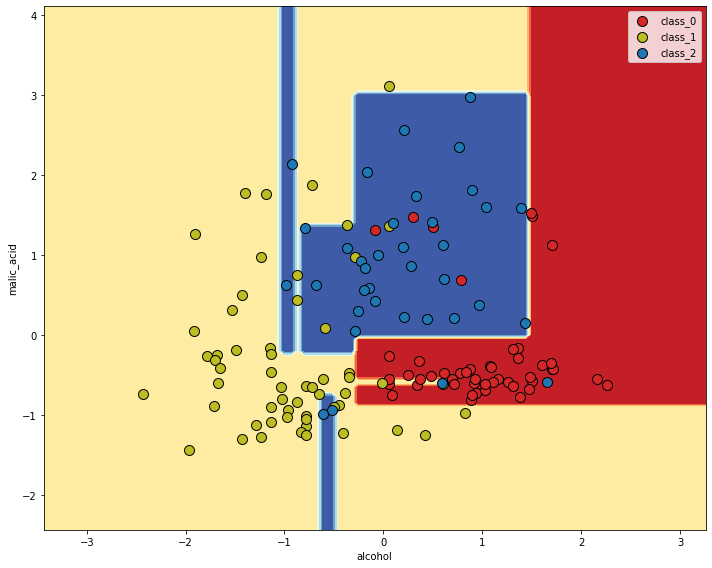

In [ ]:
#Setup4
clf = DecisionTreeClassifier(criterion = 'entropy',random_state=seed, max_depth=6)
clf.fit(wine_X_train[:,:2],wine_y_train)
plot_decision_boundary(
    clf,
    wine_X_train,
    wine_y_train,
    (feature1, feature2),
    feature_names,
    target_names
)
accuracy = clf.score(wine_X_test[:,:2],wine_y_test)
precision = precision_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')
f1 = f1_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("F1 score: ",f1)

Accuracy:  0.6944444444444444
Precision:  0.6871794871794873
F1 score:  0.6853071780608012


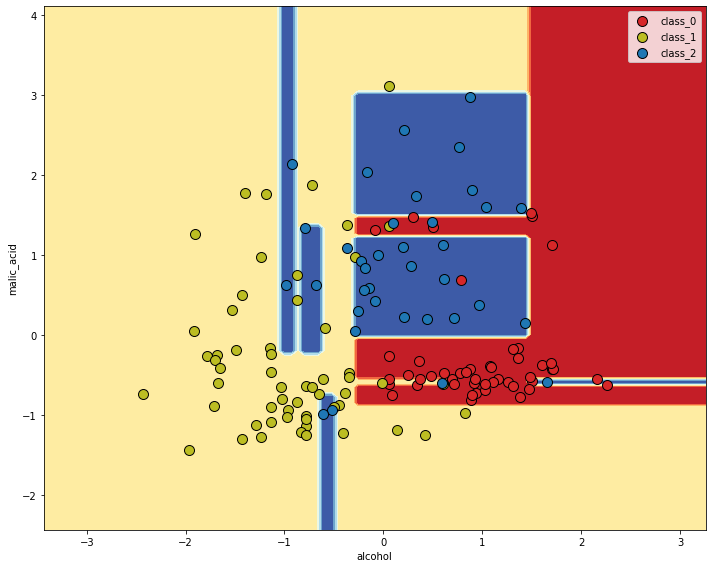

In [ ]:
#Setup5
clf = DecisionTreeClassifier(criterion = 'entropy',random_state=seed, max_depth=7)
clf.fit(wine_X_train[:,:2],wine_y_train)
plot_decision_boundary(
    clf,
    wine_X_train,
    wine_y_train,
    (feature1, feature2),
    feature_names,
    target_names
)
accuracy = clf.score(wine_X_test[:,:2],wine_y_test)
precision = precision_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')
f1 = f1_score(wine_y_test,clf.predict(wine_X_test[:,:2]), average='macro')

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("F1 score: ",f1)

The optimal configurations are:

criterion = entropy

max_depth = 4 and 5

Scores:

Accuracy:  0.7777777777777778

Precision:  0.7703703703703703

F1 score:  0.7634970393591082

Upon increasing the depth to 7 from 5, there was a fall in the performance. 

# Section 2. Support Vector Machines [ 25 points ]

In this section, you will experiment with different datasets using SciKit-Learn's implementation of support vector machines (SVMs). This will give you better intuitions about utilizing SVMs when it comes to different two-dimensional datasets. You will also implement a Gaussian kernel for non-linear SVM classification.

## 2.1. Linear SVM (5 points)

In this subsection, we will experiment with a dataset that can be separated with a linear decision boundary. We want to experiment with different $C$ values to understand their effects on our linear decision boundary.

Let's first load the dataset (`svm_data1.mat` in MatLab format) using SciPy's `loadmat()` function.

In [ ]:
data1 = loadmat(data_path / "svm_data1.mat")
X1, y1 = data1["X"], data1["y"][:, 0] # "X" and "y" are keys for this dataset
X1.shape, y1.shape # 2D samples + labels

((51, 2), (51,))

We provide code for plotting data and SVM decision boundaries below:

In [ ]:
def plot_data(X, y, ax=None):
    """Plot 2D dataset."""
    positive = (y == 1)
    negative = (y == 0)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(X[positive, 0], X[positive, 1], "X", mew=1, ms=10, mec="k")
    ax.plot(X[negative, 0], X[negative, 1], "o", mew=1, mfc="tab:olive", ms=10, mec="k")


def plot_linear_boundary(X, y, model, ax=None):
    """Plot linear boundary."""
    if model is None:
        return
    w = model.coef_[0]    # the theta of your SVM classifier
    b = model.intercept_  # the bias of your SVM classifier
    xp = np.array([np.min(X[:, 0]), np.max(X[:, 0])])
    yp = -(w[0] * xp + b) / w[1]
    if ax is None:
        fig, ax = plt.subplots()
    plot_data(X, y, ax)
    ax.plot(xp, yp)
    
    
def plot_nonlinear_boundary(X, y, model, ax=None):
    """Contour plot that delineates a nonlinear boundary."""
    if model is None:
        return
    
    num_points = math.floor(X.shape[0]/10)
    x1 = np.linspace(min(X[:, 0]), max(X[:, 0]), num_points)
    x2 = np.linspace(min(X[:, 1]), max(X[:, 1]), num_points)
    X1, X2 = np.meshgrid(x1, x2)
    vals = np.zeros(X1.shape)
    for i in range(X1.shape[1]):
        X_ = np.stack((X1[:, i], X2[:, i]), axis=1)
        vals[:, i] = model.predict(X_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.contourf(X1, X2, vals, cmap="YlGnBu", alpha=0.2)    
    plot_data(X, y, ax)

We want to first visualize our dataset in two-dimensional space:

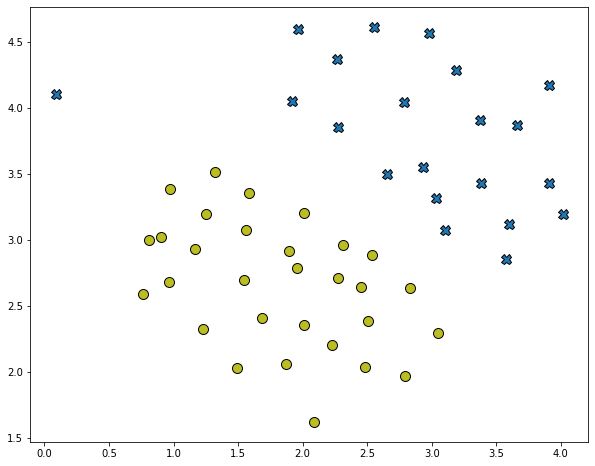

In [ ]:
# Plot training data
plot_data(X1, y1)

(1) Describe the dataset. How does it lend itself well to the use of an SVM? Are there any abnormalities that may affect our model's performance? (2 points)

**_Your answer:_** The dataset has two classes of data. This distribution of data is a good fit for SVM as can be in the plot above. SVM would try to draw a hyperplane while trying to maintain the max distance from the distributions and as can be seen the data is quite uniformly distributed around the gap between them where a hyperplane ( a line since this is in R2) could be fit in. However, despite the favorable distribution of the data, there is a sample from class "1" which is an outlier and thus will affect the model's performance.

Now, we want to train linear SVMs for our dataset. You should pick **6 different $C$ values** to train your SVMs, then plot all of them side by side for convenient juxtaposition. You should train your models with **L2 penalty** and **hinge loss**. Use the provided `seed`. We provide code for side-by-side plots below.

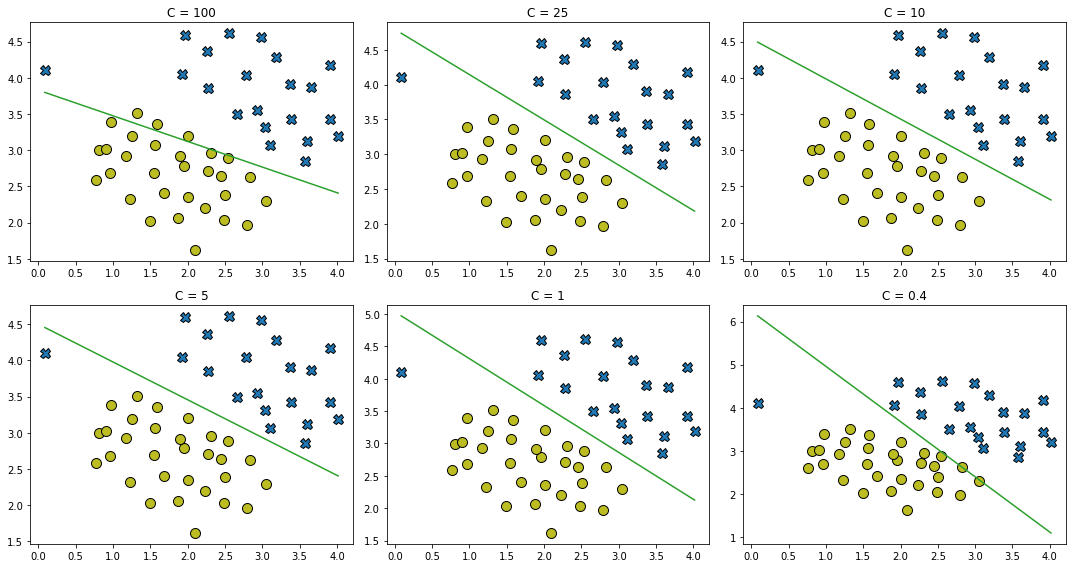

In [ ]:
from sklearn import svm
import math
from sklearn.svm import LinearSVC

# TODO: Replace None's with appropriate values
Cs = [100, 25, 10, 5, 1, 0.4]

cols = 3
rows = math.ceil(len(Cs) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
for row in range(rows):
    for col in range(cols):
        C = Cs[row * cols + col]
        # TODO: Train SVM
        svm_clf = LinearSVC( penalty='l2',loss='hinge',C = C, random_state = seed)
        svm_clf.fit(X1,y1)
        # End of code
        plot_linear_boundary(X1, y1, svm_clf, axes[row, col])
        axes[row, col].set_title(f"C = {C}")
plt.tight_layout()

(2) What does $C$ intuitively represent, and how does varying it affect our SVM's decision boundary, according to the graphs? Take into account any abnormalities mentioned above. (3 points)

**_Your answer:_** The C parameter tells the SVM optimization how much to avoid misclassifying each training example. When C is large, the distance between the distribution and the hyperplane is more because it tries harder not to misclassify so samples of different classes are further away. Conversely, a very small value of C will cause the optimizer to make a hyperplane that has very little distance between samples and itself, even if that hyperplane misclassifies more points. Thus, when C = 100, it tries not to misclassify even the outlier and ends of having a non optimal hyperplane while when C = 0.4, the margin between samples and hyperplane is so less it ends up misclassifying as well. 

## 2.2. Kernel SVM (20 points)

In this part of the homework, you will perform non-linear classification using SVMs, with Gaussian kernels in particular.

### 2.2.1. Gaussian Kernel (10 points)

Similarly to Gaussian basis functions, we can use Gaussian kernels to find non-linear decision boundaries. As mentioned in lectures and chapter 6.2 of the Bishop textbook (page 296), these kernels are of the form:

$$
    k(\mathbf{x}, \mathbf{x}') = \exp \left\{ -\frac{\lVert\mathbf{x} - \mathbf{x}'\rVert^2}{2\sigma^2}\right\}
$$

Implement a Gaussian kernel matrix for our SVMs below. We will be using [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) as our model.

In [ ]:
def gaussian_kernel(x, x_prime, sigma):
    k = np.zeros((x.shape[0], x_prime.shape[0]))
    # TODO: Implement Gaussian kernel matrix
    for i,x in enumerate(x):
      for j,y in enumerate(x_prime):
        k[i,j]=np.exp((-1*np.linalg.norm(x-y)**2)/(2.0*(sigma)**2))
    # End of code
    return k

Note that according to [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), our resulting kernel matrix should have size `(n_samples, n_samples)`. Once you have completed the implemetation of `gaussian_kernel_matrix()`, the following cell will test your kernel function on two provided examples, after which you should expect to see a value of:

<pre>
[[1.         0.32465247]
 [0.32465247 1.        ]]
</pre>

In [ ]:
x1 = np.array([[1, 2, 1],[0, 4, -1]])
x2 = np.array([[1, 2, 1],[0, 4, -1]])
sigma = 2.0

kernel_matrix = gaussian_kernel(x1, x2, sigma)
print(kernel_matrix)

[[1.         0.32465247]
 [0.32465247 1.        ]]


### 2.2.2. Training SVM with a Gaussian Kernel (5 points)

Let's demonstrate a Gaussian-kernel SVM on a non-linear dataset:

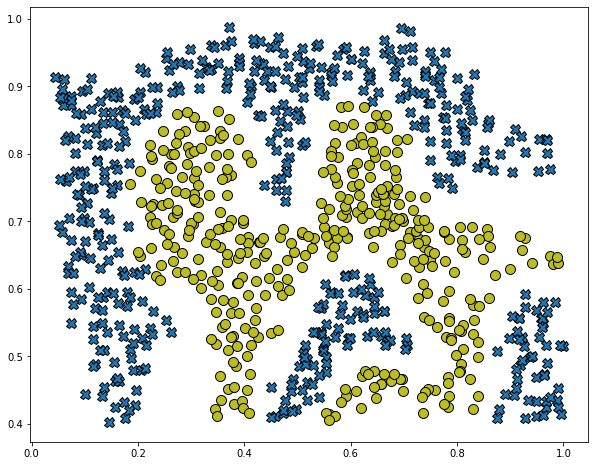

In [ ]:
data2 = loadmat(data_path / "svm_data2.mat")
X2, y2 = data2["X"], data2["y"][:, 0]
plot_data(X2, y2)

Apply a Gaussian kernel to your non-linear SVC model below; an SVC example with a custom kernel is available [here](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html). Note the kernel's input arguments.

In [ ]:
def kernel_wrapper(f, sigma):
  return lambda x, x_prime: f(x, x_prime, sigma)

In [ ]:
from sklearn.svm import SVC

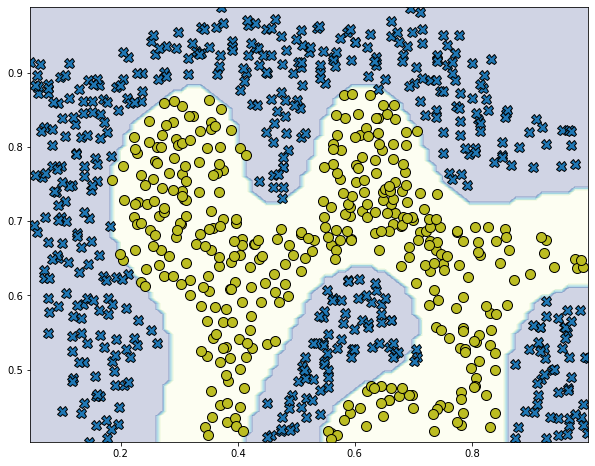

In [ ]:
sigma = 0.1
# TODO: Apply Gaussian kernel on SVC with provided seed as random_state
model = SVC(kernel=kernel_wrapper(gaussian_kernel, sigma), random_state=seed)
model.fit(X2,y2)
# End of code
plot_nonlinear_boundary(X2, y2, model) # note that this step could take up to 1 minute

### 2.2.3. Grid Search Cross Validation (5 points)

In this part of the homework, you will utilize cross validation with a validation set to finetune your model. You will use Gaussian-kernel SVMs for this task. From the provided dataset (`svm_data3.mat`), you are given a train and validation set:

Text(0.5, 1.0, 'Validation set')

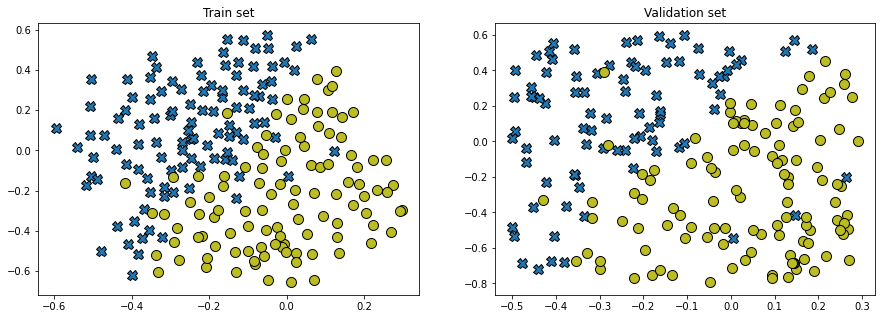

In [ ]:
data3 = loadmat(data_path / "svm_data3.mat")

X_train = data3["X"]
y_train = data3["y"][:, 0]
X_val = data3["Xval"]
y_val = data3["yval"][:, 0]

# Plot training and validation data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_data(X_train, y_train, ax1)
plot_data(X_val, y_val, ax2)
ax1.set_title("Train set")
ax2.set_title("Validation set")

Here, you are to use the validation set (`X_val`, `y_val`) to determine the best combination of $C$ and $\sigma$ parameters for your SVM, using accuracy as your metric. We suggest trying values in multiplicative steps for these parameters (e.g., 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30). You should try all possible pairs of values for $C$ and $\sigma$. For example, trying every possible combination of the 2 parameters among the 8 values listed above would result in $8^2 = 64$ different models being trained and validated. Because this could take a long time, we suggest reserving time to work on this section.

Write code to determine the best combination of $C$ and $\sigma$ as well as to return the corresponding values in `search_hyperparameter()` below.

In [ ]:
from sklearn.model_selection import GridSearchCV

def return_kernel_values(sigmas):
      kernel_values=[]
      for sigma in sigmas:
        kernel_values.append(kernel_wrapper(gaussian_kernel, sigma))
      return kernel_values

In [ ]:
def search_hyperparameter(X_train, y_train, X_val, y_val, Cs, sigmas):
    # TODO: Grid search
    hyperparameter_space={'C':Cs, 'kernel': return_kernel_values(sigmas)}
    gs=GridSearchCV(SVC(kernel=kernel_wrapper(gaussian_kernel, sigma), random_state=seed),param_grid=hyperparameter_space,scoring="accuracy",n_jobs=4, return_train_score=True, verbose=True)
    
    gs.fit(X_val, y_val)
    best_C = gs.best_params_['C']
    best_sigma = gs.best_params_['kernel']
    best_accuracy = gs.best_score_
    best_model = gs.best_estimator_
    return best_C, best_sigma, best_accuracy, best_model

Report the best performing parameters along with the accuracy score on `X_val`. You should be able to get an accuracy higher than 0.9. The optimal parameters may not be unique.

In [ ]:
Cs = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
sigmas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

# TODO: Try different SVM hyperparameters
best_C, best_sigma, best_accuracy, best_model = search_hyperparameter(X_train, y_train, X_val, y_val, Cs, sigmas)

print("Best C value: ", best_C)
print("Best sigma value: ", best_sigma)
print("Optimum accuracy score: ", best_accuracy)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best C value:  0.3
Best sigma value:  <function kernel_wrapper.<locals>.<lambda> at 0x7f5c295e6320>
Optimum accuracy score:  0.9400000000000001


In [ ]:
print("Optimal paramters", best_model)

Optimal paramters SVC(C=0.3, kernel=<function kernel_wrapper.<locals>.<lambda> at 0x7f5c295e6320>,
    random_state=5824)


Lastly, train the model again with your optimal parameters and plot the decision boundary.

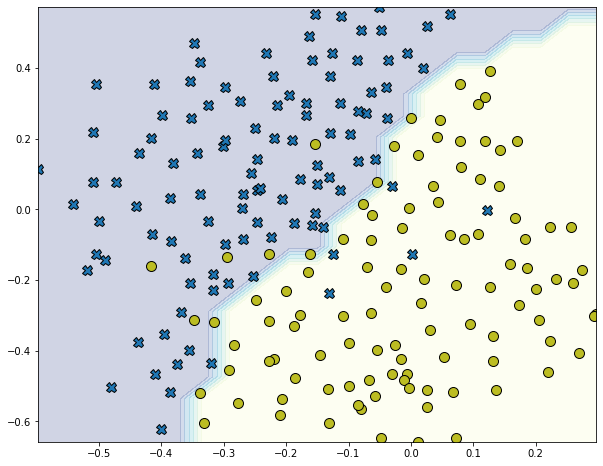

In [ ]:
# TODO: Train and plot model with best configuration
best_model.fit(X_train,y_train)
plot_nonlinear_boundary(X_train, y_train, best_model)

In [ ]:
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc 
!pip install --quiet pypandoc

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-droid-fallback.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../00-fonts-droid-fallback_1%3a6.0.1r16-1.1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1) ...
Selecting previously unselected package fonts-lato.
Preparing to unpack .../01-fonts-lato_2.0-2_all.deb ...
Unpacking fonts-lato (2.0-2) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../02-poppler-data_0.4.8-2_all.deb ...
Unpacking poppler-data (0.4.8-2) ...
Selecting previously unselected package tex-common.
Preparing to unpack .../03-tex-common_6.09_all.deb ...
Unpacking tex-common (6.09) ...
Selecting previously unselected package fonts-lmodern.
Preparing to unpack .../04-fonts-lmodern_2.004.5-3_all.deb ...
Unpacking fonts-lmodern (2.004.5-3) ...
Selecting previously unselected package fonts-noto-mono.
Preparing to unpack .

In [ ]:
!jupyter nbconvert --to PDF "/content/gdrive/MyDrive/Colab Notebooks/AmartyaDuttaSectionB_HW2.ipynb"

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Colab Notebooks/AmartyaDuttaSectionB_HW2.ipynb to PDF
[NbConvertApp] Support files will be in AmartyaDuttaSectionB_HW2_files/
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./AmartyaDuttaSectionB_HW2_files
[NbConvertApp] Making directory ./A